In [1]:
from IPython.display import HTML
HTML('<img src="./giphy5.gif">')

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
train_df = pd.read_csv('./UTKFace/train_split.csv')

test_df_final = pd.read_csv('./UTKFace/test_split.csv')

valid_df = pd.read_csv('./UTKFace/valid_split.csv')

augmented_train_df = pd.read_csv('./UTKFace/augmented_train_split.csv')

combined_train_df = pd.read_csv('./UTKFace/combined_train_split.csv')

C:\Users\anoop\AppData\Local\Temp\ipykernel_5388\3756340081.py:9: DtypeWarning: Columns (3,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_train_df = pd.read_csv('./UTKFace/combined_train_split.csv')


In [3]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence

In [4]:
class DataGenerator(Sequence):
    def __init__(self, df, directory, batch_size=16, dim=(224, 224), n_channels=3, shuffle=True, use_augmented=False):
        self.df = df.copy()
        self.directory = directory
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.use_augmented = use_augmented
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[indexes]
        X, y = self.__data_generation(batch_df)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_df):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        for i, row in enumerate(batch_df.itertuples()):
            
            if self.use_augmented and 'original_' in row.file_name:
                original_part = row.file_name.split('original_')[1]
                file_path = os.path.join(self.directory, row.combined_category, "output", row.combined_category + '_original_' + original_part)
            
            elif self.use_augmented:
                file_path = os.path.join(self.directory, row.combined_category, row.file_name)
            
            else:
                file_path = os.path.join("./UTKFace/", row.file_name)

            img = cv2.imread(file_path)
            if img is None:
                print(f"Failed to load image at path: {file_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.dim)
            X[i, ] = img / 255.0  
            y[i] = row.age

        return X, y

In [5]:
age_mapping = {
    "Children" : 0,
    "Teenagers" : 1,
    "Young Adults" : 2,
    "Adults" : 3,
    "Seniors" : 4
}

race_mapping = {
    "White" : 0,
    "Black" : 1,
    "Asian" : 2,
    "Indian" : 3,
    "Others" : 4
}

gender_mapping = {
    "Male" : 0,
    "Female" : 1
}

reverse_age_mapping = {v:k for k,v in age_mapping.items()}
reverse_race_mapping = {v:k for k,v in race_mapping.items()}
reverse_gender_mapping = {v:k for k,v in gender_mapping.items()}

In [6]:
directory_path = "./UTKFace/"
train_images_path = './UTKFace/train/'

In [7]:
combined_train_df['age'] = combined_train_df['age'].clip(upper=65)
valid_df['age'] = valid_df['age'].clip(upper=65)
test_df_final['age'] = test_df_final['age'].clip(upper=65)

In [8]:
train_generator = DataGenerator(df=combined_train_df, directory=train_images_path, batch_size=16, dim=(224, 224), n_channels=3, shuffle=True, use_augmented=True)
validation_generator = DataGenerator(df=valid_df, directory=directory_path, batch_size=16, dim=(224, 224), n_channels=3, shuffle=False, use_augmented=False)
test_generator = DataGenerator(df=test_df_final, directory=directory_path, batch_size=16, dim=(224, 224), n_channels=3, shuffle=False, use_augmented=False)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def r_squared(y_true, y_pred):
    SS_res = tf.reduce_mean(tf.square(y_true - y_pred))
    SS_tot = tf.math.reduce_variance(y_true)
    return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))


def build_model_2():
    base_model2 = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model2.trainable = False
    
    for layer in base_model.layers[:10]:
        layer.trainable = False
    for layer in base_model.layers[10:]:
        layer.trainable = True  

    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    for i in range(1,6):
        x = Dense(hp.Int(f'units_{i}', min_value = 16, max_value = 128, step = 16),activation= 'relu', kernal_regularization = l2(hp.Float(f'12_{i}', min_value= 1e-5,max_value = 1e-2, sampling='Log')))
        x = Dropout(hp.Float(f'Dropout_{i}', min_value = 0.0, max_value = 0.5, step = 0.1))(x)
        
    predictions = Dense(1, activation="linear")(x)
    model2 = Model(inputs=base_model.input, outputs=predictions)
    model2.compile(optimizer=Adam(hp.Float(f'learning_rate', min_value= 1e-5,max_value = 1e-2, sampling='Log', loss = 'mse', metrics = ['mae',r_squared])))
    return model


from tensorflow.keras.callbacks import EarlyStopping

tuner2 = RandomSearch(
build_model_2,
objective = 'val_mae',
max_trails = 20,
executions_per_trail = 1,
directory='model_tuning',
project_name = 'age_estimation_2')

tuner2.search_space_summary()

tuner2.search(
    train_generator,
    epochs = 15,
    validation_data = validation_generator,
    callbacks = [EarlyStopping('val_loss', patience = 3)]
)

base_model2 = tuner2.get_best_models(num_models = 1)[0]
base_model2.summary()

### Best Parameters: 
| Layer | neurons | Dropout | Reg |
| --- | ---| ---| --- |
| 1 | 64 | 0.0 | 0.0052782838119634886 |
| 2 | 112 | 0.0 | 0.0009340024837276483 |
| 3 | 112 | 0.3 | 0.00209281206218846 |
| 4 | 48 | 0.1 | 9.48604366516959e-05 |
| 5 | 32 | 0.2 | 0.0001280320402829348 |

* Learning_rate = 0.00035651567891962404

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def r_squared(y_true, y_pred):
    SS_res = tf.reduce_mean(tf.square(y_true - y_pred))
    SS_tot = tf.math.reduce_variance(y_true)
    return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))


def build_model_with_best_hps():
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    
    for layer in base_model.layers[:10]:
        layer.trainable = False
    for layer in base_model.layers[10:]:
        layer.trainable = True  

    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    
    dense_layers = [
        (64, 0.0, 0.0052782838119634886),
        (112, 0.0, 0.0009340024837276483),
        (112, 0.3, 0.00209281206218846),
        (48, 0.1, 9.48604366516959e-05),
        (32, 0.2, 0.0001280320402829348)
    ]

    for units, dropout_rate, l2_value in dense_layers:
        x = Dense(units, activation="relu", kernel_regularizer=l2(l2_value))(x)
        x = Dropout(dropout_rate)(x)

    predictions = Dense(1, activation="linear")(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


early_stopping = EarlyStopping(
    monitor='val_mae',  
    patience=10,         
    verbose=1,
    restore_best_weights=True  
)

model = build_model_with_best_hps()
model.compile(optimizer=Adam(learning_rate=0.00035651567891962404),
              loss="mse", 
              metrics=["mae", r_squared])


model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

                                                                                                  
 block_3_expand_BN (BatchNo  (None, 56, 56, 144)          576       ['block_3_expand[0][0]']      
 rmalization)                                                                                     
                                                                                                  
 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)

                                                                                                  
 block_6_depthwise (Depthwi  (None, 14, 14, 192)          1728      ['block_6_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_p

                                                                    ']                            
                                                                                                  
 block_9_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_9_project[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_

 block_13_expand (Conv2D)    (None, 14, 14, 576)          55296     ['block_12_add[0][0]']        
                                                                                                  
 block_13_expand_BN (BatchN  (None, 14, 14, 576)          2304      ['block_13_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
          

 block_16_expand_relu (ReLU  (None, 7, 7, 960)            0         ['block_16_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_16_depthwise (Depthw  (None, 7, 7, 960)            8640      ['block_16_expand_relu[0][0]']
 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)     

In [ ]:
history = model.fit(train_generator, 
                    epochs=5,
                    validation_data=validation_generator,
                    callbacks=[early_stopping])

In [2]:
results = model.evaluate(test_generator)
print(f"Test Loss: {results[0]}, Test MAE: {results[1]}, Test R-Squared: {results[2]}")

* Test MAE => 5.5, Test r-square => 0.8

In [ ]:
y_pred = model.predict(test_generator)
y_true = test_df_final['age'].values[:len(y_pred)]

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Actual vs Predicted Age')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=3)
plt.show()

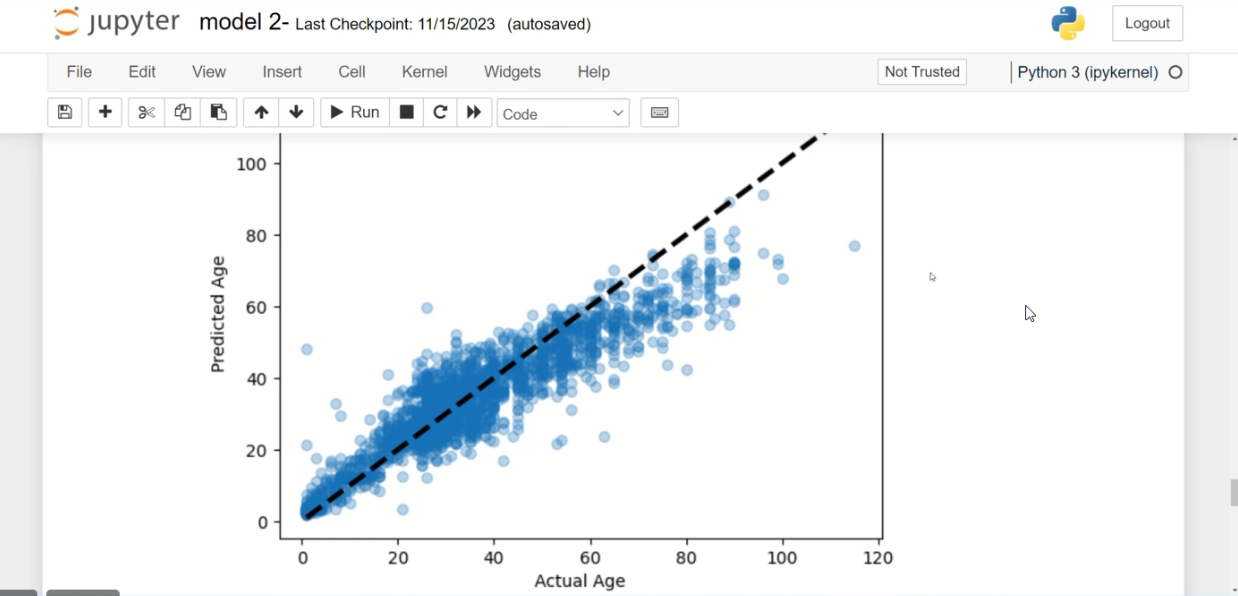

In [4]:
from PIL import Image
from IPython.display import display

img = Image.open('image2.png')
display(img)

In [5]:
from IPython.display import HTML
HTML('<img src="./giphy6.gif">')

In [ ]:
import matplotlib.pyplot as plt


history_dict = history.history


train_mae = history_dict['mae']
val_mae = history_dict['val_mae']
train_r_squared = history_dict['r_squared']
val_r_squared = history_dict['val_r_squared']

epochs = range(1, len(train_mae) + 1)

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_mae, label='Training MAE')
plt.plot(epochs, val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_r_squared, label='Training R-squared')
plt.plot(epochs, val_r_squared, label='Validation R-squared')
plt.title('Training and Validation R-squared')
plt.xlabel('Epochs')
plt.ylabel('R-squared')
plt.legend()

plt.tight_layout()
plt.show()

# Research 

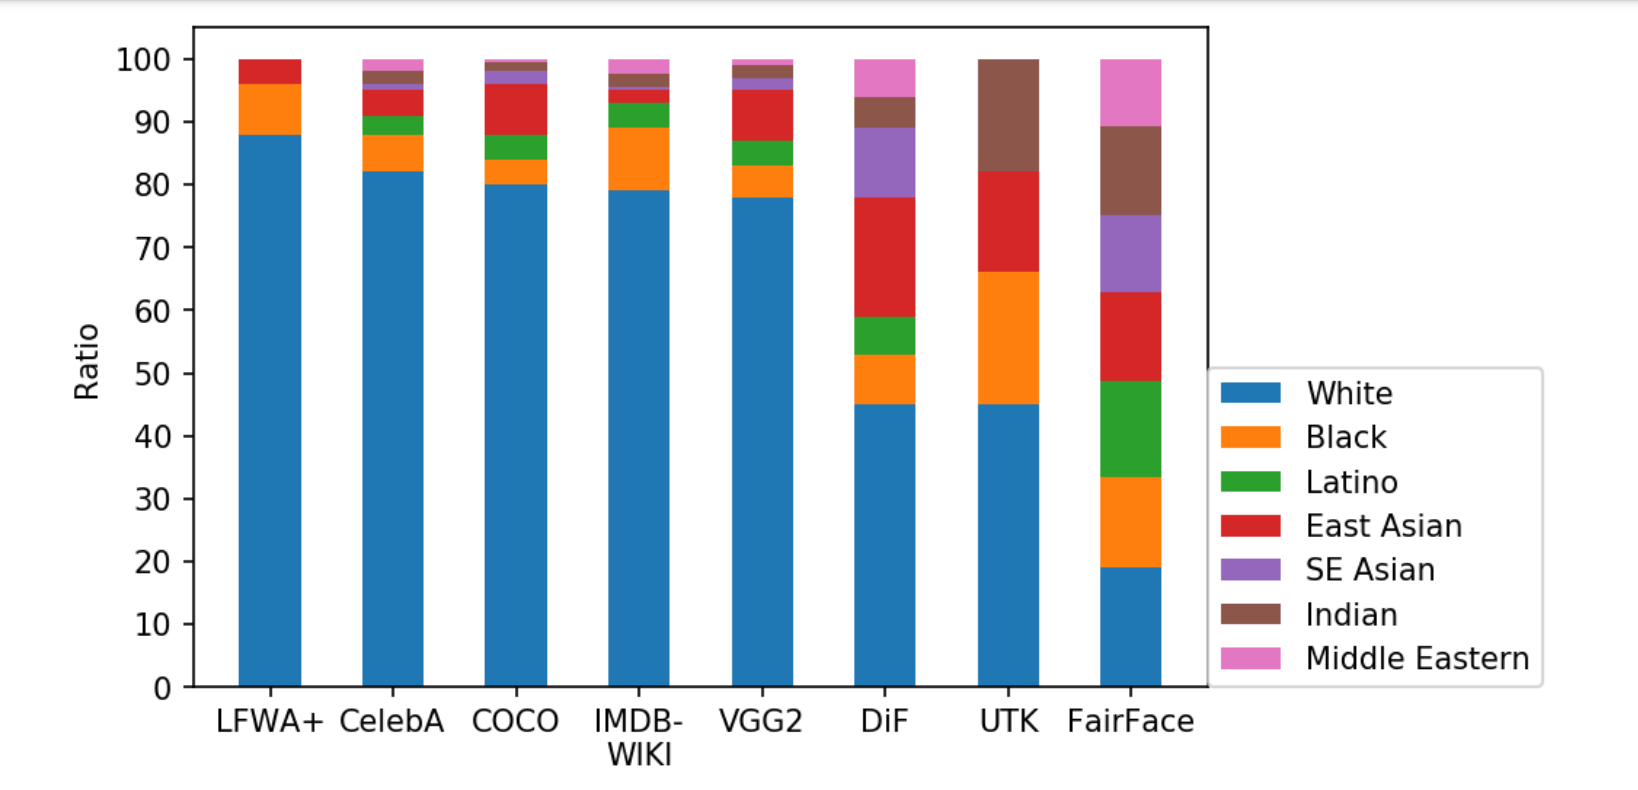

In [1]:
from PIL import Image
from IPython.display import display
img = Image.open('balance.png')
display(img)

* balanced race composition